# Human Faces - CalebA GAN

Make Your First GAN With PyTorch, 2020

In [1]:
from rich import print
import dill as pickle

## import libraries

In [2]:
import random

import torch
import torch.nn as nn

import h5py
import pandas as pd
import numpy
import matplotlib.pyplot as plt

## Standard CUDA Check And Set Up

In [3]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: NVIDIA GeForce RTX 3080

device(type='cuda')

## Dataset Class

<Figure size 432x288 with 1 Axes>

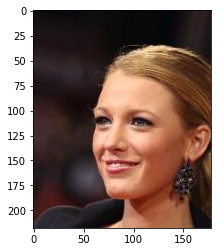

In [4]:
from celeba_data import CelebADataset

# create Dataset object
celeba_dataset = CelebADataset('celeba_aligned_small.hdf5')

# check data contains images
celeba_dataset.plot_image(21)

# Helper Functions

In [5]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [6]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

## Discriminator Network

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(218*178*3),
            
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        
        # print counter every 2000
        if (self.counter % 2000 == 0):
            print("counter = ", self.counter)

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()


    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        plt_kwargs = dict(
            ylim=(min(self.progress), max(self.progress)), 
            figsize=(16, 8), 
            alpha=0.1, 
            marker='.', 
            grid=True, 
            yticks=(0, 0.25, 0.5, 1.0, 5.0)
        )
        df.plot(**plt_kwargs)

## Test Discriminator

In [9]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))

counter =  2000

counter =  4000

counter =  6000

counter =  8000

counter =  10000

counter =  12000

counter =  14000

counter =  16000

counter =  18000

counter =  20000

counter =  22000

counter =  24000

counter =  26000

counter =  28000

counter =  30000

counter =  32000

counter =  34000

counter =  36000

counter =  38000

counter =  40000

CPU times: user 47min 23s, sys: 36min 28s, total: 1h 23min 52s
Wall time: 4min 30s


<Figure size 1152x576 with 1 Axes>

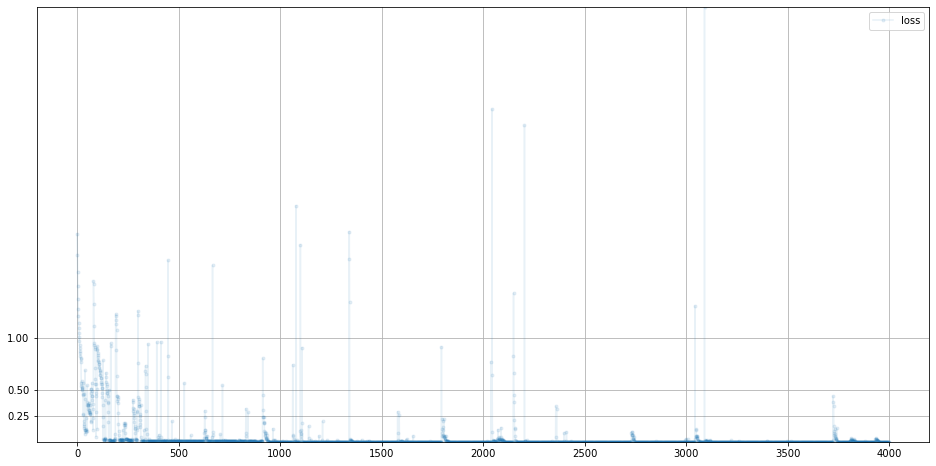

In [10]:
# plot discriminator loss

D.plot_progress()

In [18]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
    image_data_tensor = celeba_dataset[random.randint(0,20000)]
    print( D.forward( image_data_tensor ).item() )

for i in range(4):
    print( D.forward( generate_random_image((218,178,3))).item() )

0.999690055847168

0.9999303817749023

0.9998873472213745

0.9997521042823792

8.836002234602347e-05

9.0548608568497e-05

8.991550566861406e-05

9.015297837322578e-05

## Generator Network

In [19]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((218,178,3))
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

  
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        plt_kwargs = dict(
            ylim=(min(self.progress), max(self.progress)), 
            figsize=(16, 8), 
            alpha=0.1, 
            marker='.', 
            grid=True, 
            yticks=(0, 0.25, 0.5, 1.0, 5.0)
        )
        df.plot(**plt_kwargs)

## Test Generator Output

<matplotlib.image.AxesImage object at 0x7f242c59fee0>

<Figure size 432x288 with 1 Axes>

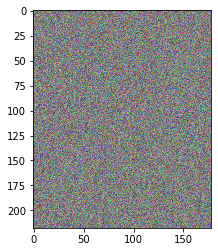

In [20]:
# check the generator output is of the right type and shape

G = Generator()
# move model to cuda device
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

## Train GAN

In [21]:
%%time 

# create Discriminator and Generator

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
    print(f"epoch = {epoch + 1}")

    # train Discriminator and Generator
    for image_data_tensor in celeba_dataset:
        # train discriminator on true
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

        # train discriminator on false
        # use detach() so gradients in G are not calculated
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

        # train generator
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

epoch = 1

counter =  2000

counter =  4000

counter =  6000

counter =  8000

counter =  10000

counter =  12000

counter =  14000

counter =  16000

counter =  18000

counter =  20000

counter =  22000

counter =  24000

counter =  26000

counter =  28000

counter =  30000

counter =  32000

counter =  34000

counter =  36000

counter =  38000

counter =  40000

CPU times: user 41min 14s, sys: 43min 3s, total: 1h 24min 17s
Wall time: 6min 15s


<Figure size 1152x576 with 1 Axes>

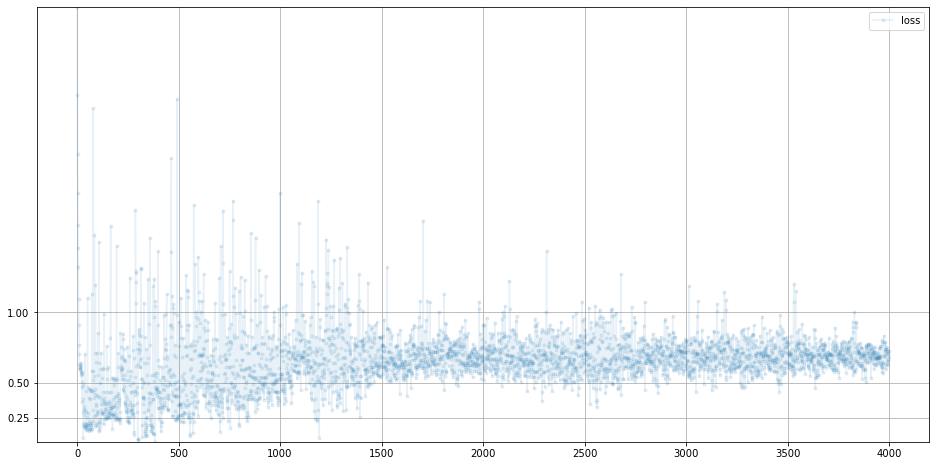

In [22]:
# plot discriminator error

D.plot_progress()

<Figure size 1152x576 with 1 Axes>

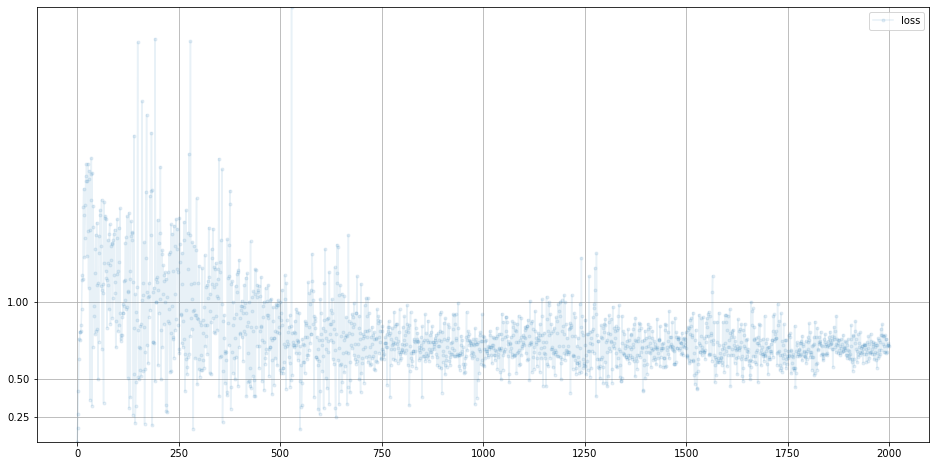

In [23]:
# plot generator error

G.plot_progress()

## Run Generator

<Figure size 1152x576 with 6 Axes>

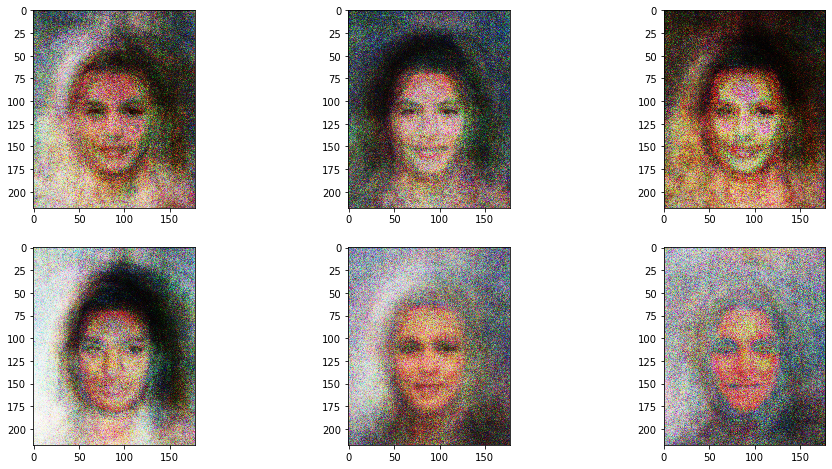

In [29]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

# Memory Consumption

In [30]:
# current memory allocated to tensors (in Gb)

torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.6999893188476562

In [31]:
# total memory allocated to tensors during program (in Gb)

torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.093554973602295

In [32]:
# summary of memory consumption

print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  733992 KB |    1119 MB |   19250 GB |   19249 GB |
|---------------------------------------------------------------------------|
| Active memory         |  733992 KB |    1119 MB |   19250 GB |   19249 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    1220 MB |    1220 MB |    1220 MB |       0 B  |
|---------------------------------------------------------------------------|
| Non-releasable memory |    9432 KB |   12114 KB |  538730 MB |  538721 MB |
|---------------------------------------------------------------------------|
| Allocations           |      56    |      85    |    4481 K  |    4481 K  |
|---------------------------------------------------------------------------|
| Active allocs         |      56    |      85    |    4481 K  |    4481 K  |
|---------------------------------------------------------------------------|
| GPU reserved segments |      16    |      16    |      16    |       0    |
|---------------------------------------------------------------------------|
| Non-releasable allocs |      15    |      16    |    2280 K  |    2280 K  |
|---------------------------------------------------------------------------|
| Oversize allocations  |       0    |       0    |       0    |       0    |
|---------------------------------------------------------------------------|
| Oversize GPU segments |       0    |       0    |       0    |       0    |
|===========================================================================|

## pickle and save the trained GAN

In [33]:
gan = dict(discriminator=D, generator=G)

with open('gan_celeba.pkl', 'wb') as f:
    pickle.dump(gan, f)

In [34]:
with open('gan_celeba.pkl', 'rb') as f:
    gan = pickle.load(f)

<Figure size 1152x576 with 6 Axes>

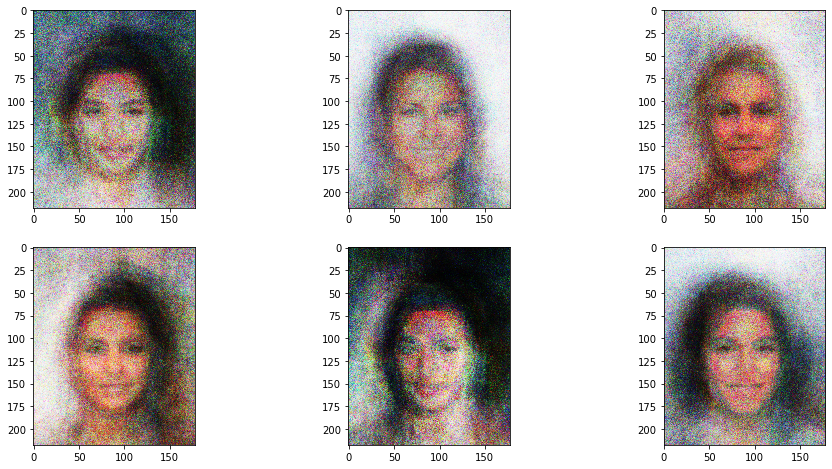

In [39]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = gan['generator'].forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')